<a href="https://colab.research.google.com/github/akshar27/Topic-Modelling-Glove-NN/blob/main/NN_Glove_Topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
blessondensil294_topic_modeling_for_research_articles_path = kagglehub.dataset_download('blessondensil294/topic-modeling-for-research-articles')

print('Data source import complete.')


In [ ]:
!pip install -qqq glove-python3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.0/327.0 kB 9.0 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import nltk
import pandas as pd
import tensorflow as tf
from glove import Corpus, Glove
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load the train dataset
train_data_path = '/kaggle/input/topic-modeling-for-research-articles/train.csv'  # Update with your local file path
train_df = pd.read_csv(train_data_path)

# Load the test dataset
test_data_path = '/kaggle/input/topic-modeling-for-research-articles/test.csv'  # Update with your local file path
test_df = pd.read_csv(test_data_path)

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# tokenize the abstract
tokenized_abstract = [word_tokenize(msg.lower()) for msg in train_df['ABSTRACT']]

# Create glove corpus and generate a co-occurance matrix
corpus = Corpus()
corpus.fit(tokenized_abstract, window=4)

#Train glove model
glove = Glove(no_components=50, learning_rate = 0.05)
glove.fit(corpus.matrix, epochs=50, no_threads=2, verbose=True)
glove.add_dictionary(corpus.dictionary)

# create a word embedding matrix
vocab_size = len(glove.dictionary)
embedding_dim = glove.no_components

# Map word to Glove Embedding
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in glove.dictionary.items():
    embedding_matrix[idx] = glove.word_vectors[idx]

Performing 50 training epochs with 2 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49


In [ ]:
# # Preprocess the text data
# def preprocess_text(text):
#     text = text.lower()
#     text = ''.join(c for c in text if c.isalnum() or c.isspace())
#     return text

# # Apply preprocessing
# train_df['cleaned_text'] = train_df['ABSTRACT'].apply(preprocess_text)

# # Convert text to a bag-of-words representation
# vectorizer = CountVectorizer(max_features=1000, stop_words='english')
# X = vectorizer.fit_transform(train_df['cleaned_text']).toarray()

# Encode the target labels
Y = train_df[['Computer Science', 'Physics', 'Mathematics', 'Statistics',
        'Quantitative Biology', 'Quantitative Finance']]  # Replace 'LABEL' with the actual column name in your dataset

In [ ]:
#convert sentences to sequences of indices
def encode_message(msg, dictionary, max_length=10):
    tokens = word_tokenize(msg.lower())
    return [dictionary.get(word, 0) for word in tokens][:max_length]

# define maximum message length
max_length = 100
encoded_messages = [encode_message(msg, glove.dictionary, max_length) for msg in train_df['ABSTRACT']]

#Pad sequences to uniform length
X = np.array([seq + [0]*(max_length-len(seq)) for seq in encoded_messages])

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define model
# model = Sequential([
#     Input(shape=(X.shape[1],)),  # Input layer
#     Dense(256, activation='relu'),          # Hidden layer 1
#     Dropout(0.3),                           # Dropout for regularization
#     Dense(128, activation='relu'),          # Hidden layer 2
#     Dropout(0.3),
#     Dense(Y_one_hot.shape[1], activation='sigmoid' if Y_one_hot.ndim > 1 else 'softmax')  # Output layer
# ])

model = Sequential([
    Embedding(input_dim = vocab_size, output_dim=embedding_dim,
             weights =[embedding_matrix] , input_length = max_length, trainable=False),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(Y.shape[1], activation='sigmoid' if Y.ndim > 1 else 'softmax')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy' if Y.ndim > 1 else 'categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,        # Adjust number of epochs
    batch_size=16,    # Adjust batch size
    verbose=1
)


Epoch 1/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5249 - loss: 0.3843 - val_accuracy: 0.6463 - val_loss: 0.3294
Epoch 2/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6557 - loss: 0.2994 - val_accuracy: 0.6163 - val_loss: 0.3164
Epoch 3/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6863 - loss: 0.2719 - val_accuracy: 0.6578 - val_loss: 0.3231
Epoch 4/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6934 - loss: 0.2609 - val_accuracy: 0.6459 - val_loss: 0.3194
Epoch 5/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7076 - loss: 0.2444 - val_accuracy: 0.6006 - val_loss: 0.3276
Epoch 6/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7137 - loss: 0.2365 - val_accuracy: 0.6173 - val_loss: 0.3330
Epoch 7/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7244 - loss: 0.2227 - val_accuracy: 0.6196 - val_loss: 0.3456
Epoch 8/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7320 - loss: 0.2150 - 

In [ ]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_val, Y_val, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Test Loss: 1.0726
Test Accuracy: 0.5577


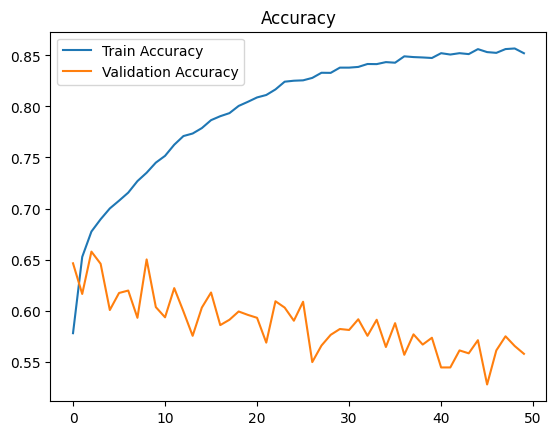

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [ ]:
# Example input text
new_text = [test_df['ABSTRACT'][10]]

# Use the same TF-IDF vectorizer as used during training
# new_texts_transformed = vectorizer.transform(new_text).toarray()

max_length = 100
encoded_messages = [encode_message(msg, glove.dictionary, max_length) for msg in new_text]

#Pad sequences to uniform length
X = np.array([seq + [0]*(max_length-len(seq)) for seq in encoded_messages])


In [ ]:
# Predict class probabilities
class_labels = ['Computer Science', 'Physics', 'Mathematics', 'Statistics',
        'Quantitative Biology', 'Quantitative Finance']  # Replace with your actual class labels

# Fit the LabelEncoder with class labels
label_encoder = LabelEncoder()
label_encoder.fit(class_labels)

predictions = model.predict(X)

# Get the predicted class indices
predicted_class_indices = predictions.argmax(axis=1)

# Convert indices back to class labels
predicted_classes = label_encoder.inverse_transform(predicted_class_indices)

# Display predictions
for text, pred in zip(new_text, predicted_classes):
    print(f"Text: {text}\nPredicted Class: {pred}\n")
